In [39]:
import sklearn.datasets
import sklearn.manifold
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.decomposition
import sklearn.linear_model
import warnings
warnings.filterwarnings('ignore')

diabetes = sklearn.datasets.load_diabetes()
data =diabetes['data'] 
y = diabetes['target'] 
diabetes['feature_names']


['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

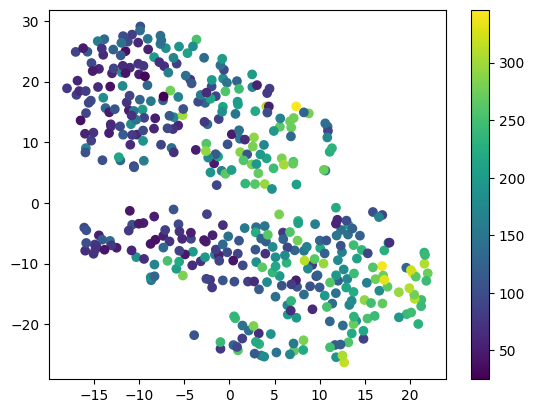

In [40]:
#Task 4a
tsne = sklearn.manifold.TSNE(2)
tsne_result = tsne.fit_transform(data)
x_vals = tsne_result[:,0]
y_vals = tsne_result[:,1]
plt.scatter(x_vals, y_vals, c=y)
plt.colorbar()
plt.show()

Task 4b

These culsters correspond to the feature sex. Below is the plot of the culsters corresponding to this feature 

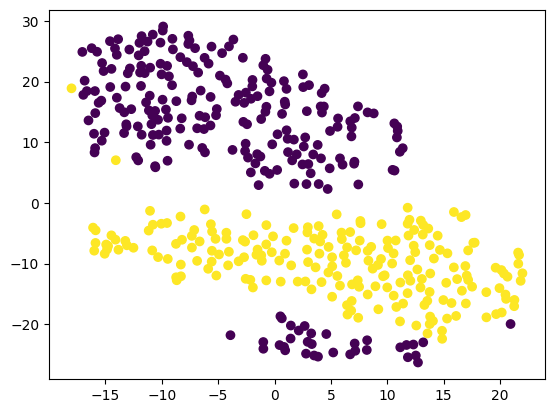

In [41]:
#Task 4b
plt.scatter(x_vals, y_vals, c=data[:,1])
plt.show()

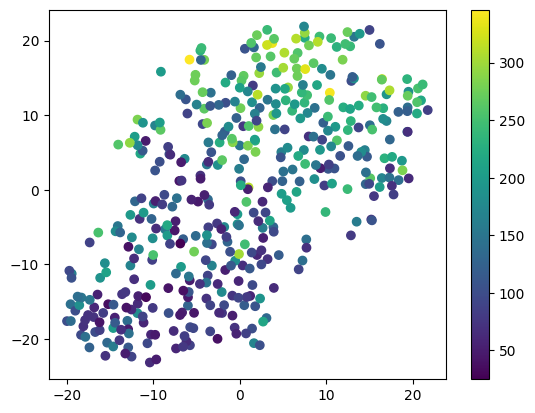

In [42]:
#Task 4c
removed_feature_sex_data = data.copy()
removed_feature_sex_data = np.delete(removed_feature_sex_data, 1, 1)
tsne_result_sex = tsne.fit_transform(removed_feature_sex_data)
x_vals_sex = tsne_result_sex[:,0]
y_vals_sex = tsne_result_sex[:,1]
plt.scatter(x_vals_sex, y_vals_sex, c=y)
plt.colorbar()
plt.show()

4c

We now observe that tsne does not result in 2 separate oblong clusters. This is because we have removed sex, so tsne is not splitting on this feature. As sex has 2 values on this dataset (male of female), we got 2 clusters. As this feature is removed, tsne is splitting on some other feature, which has multiple values, and hence we are not getting 2 seperate clusters

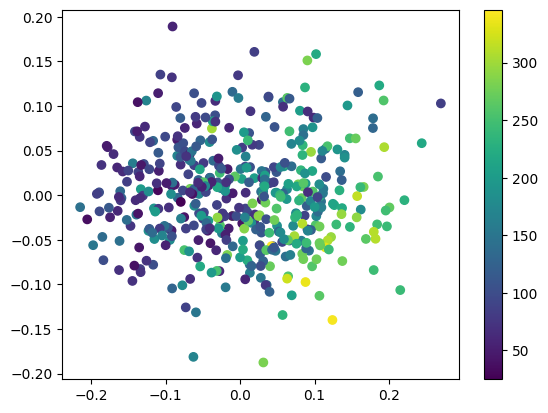

In [43]:
#Task 4d
pca = sklearn.decomposition.PCA(2)
pca_result = pca.fit_transform(data)
x_values = pca_result[:,0]
y_values = pca_result[:,1]
plt.scatter(x_values, y_values, c=y)
plt.colorbar()
plt.show()

4e

I have calculated the solution for w*, b* by hand. The calculation is on a different page, which I am am refering to in the code

In [44]:
#Task 4e
from itertools import tee
from operator import inv

from numpy import mat, ones


X_train = data[:100]
X_test = data[100:]
Y_train = y[:100].reshape(-1,1)
Y_test = y[100:].reshape(-1,1)
ones_vector = np.ones((X_train.shape[0], 1))
ones_vector_test = np.ones((X_test.shape[0], 1))

#Computing the matrix, which I calculated by hand in step 1.
# This is the matrix denoted as matrix A by hand:
# [xTx xT1]
# [1Tx 1T1]

def compute_matrix(x, y, ones_vector):
    matrix_upper = np.append(x.T@x, x.T@ones_vector, axis =1)
    marix_lower = np.append(ones_vector.T@x, ones_vector.T@ones_vector, axis=1)
    matrix = np.append(matrix_upper, marix_lower, axis=0)
    return matrix

#Computing the y vector, which I calculated by hand in step 1.
# The vector is denoted as y in my calculation:
#[xTy]
#[1Ty]
def compute_y_vector(x, y, ones_vector):
    return np.append(x.T@y, ones_vector.T@y, axis=0)

#Computing the result if [w b] by taking the inverse of the matrix,
# multiplied by the y vector as showed in my calculation by hand.
# This is step 2 in my calculation by hand
def compute_result(matrix, vector):
    return np.linalg.inv(matrix)@vector

#Finding w
def compute_w(result):
    return np.delete(result, -1).reshape(-1,1)
    
#Finding b (bias)
def compute_b(result):
    return  result[-1]

def compute_mse(x, y, w_ols, b_ols, ones_vector):
    return np.linalg.norm(x@w_ols+b_ols*ones_vector-y,2)**2/x.shape[0]

matrix = compute_matrix(X_train, Y_train, ones_vector)
y_vector = compute_y_vector(X_train, Y_train, ones_vector)
result = compute_result(matrix, y_vector)
w_ols = compute_w(result)
b_ols = compute_b(result)
mse = compute_mse(X_test, Y_test, w_ols, b_ols, ones_vector_test)
    
print("The MSE ols is: ", mse)


The MSE ols is:  3430.923382600538


In [45]:
#4e
y_hatt_test = X_test@w_ols+b_ols*ones_vector_test

def find_pairs(Y, Y_hatt):
    concordant_pairs = 0
    discordant_pairs = 0
    for i in range(0, Y.shape[0]):
        for j in range(0, Y.shape[0]):
            if Y[i] > Y[j] and Y_hatt[i] > Y_hatt[j] and j!= i:
                concordant_pairs+=1
            if Y[i] > Y[j] and Y_hatt[i] < Y_hatt[j] and j!= i:
                discordant_pairs +=1
    return concordant_pairs, discordant_pairs

concordant_pairs, discordant_pairs = find_pairs(Y_test, y_hatt_test)

def caclulate_c_index(concordant_pairs, discordant_pairs):
    return concordant_pairs/(concordant_pairs+discordant_pairs)

c_index = caclulate_c_index(concordant_pairs, discordant_pairs)

print("The c-index is: ", c_index)


The c-index is:  0.7452930850514576


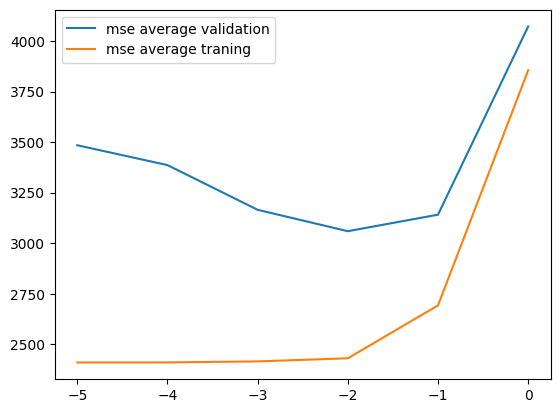

In [46]:
#4f

#K-fold of traning set X
cross_val_training_x = [X_train[:10], X_train[10:20],
 X_train[20:30], X_train[30:40],
 X_train[40:50],X_train[50:60], X_train[60:70],
 X_train[70:80], X_train[80:90], X_train[90:100]]

#K-fold of traning set Y
cross_val_training_y = [Y_train[:10], Y_train[10:20],
 Y_train[20:30], Y_train[30:40],
 Y_train[40:50],Y_train[50:60], Y_train[60:70],Y_train[70:80],
  Y_train[80:90], Y_train[90:100]]


def compute_matrix_ridge(x, y, ones_vector, lam):
    matrix_upper = np.append(x.T@x+lam*np.identity(x.shape[1]), x.T@ones_vector, axis =1)
    marix_lower = np.append(ones_vector.T@x, ones_vector.T@ones_vector, axis=1)
    matrix = np.append(matrix_upper, marix_lower, axis=0)
    return matrix

lambdas = [10**(-5), 10**(-4), 10**(-3), 10**(-2), 10**(-1), 1]
average_mse_values = []
average_mse_values_traning = []
for lambda_i in lambdas:
    mse_average = 0
    mse_averag_tranining = 0
    for i in range(10):
        validation_x = np.array(cross_val_training_x[i])
        validation_y = np.array(cross_val_training_y[i])

        train_x = np.concatenate(np.delete(cross_val_training_x.copy(), i, axis=0))
        train_y = np.concatenate(np.delete(cross_val_training_y.copy(), i, axis=0))

        ones_vector_1 = np.ones((train_x.shape[0], 1))
        ones_vector_test_1 = np.ones((train_x.shape[1], 1))

        matrix = compute_matrix_ridge(train_x, train_y, ones_vector_1, lambda_i)
        y_vector = compute_y_vector(train_x, train_y, ones_vector_1)
        result = compute_result(matrix, y_vector)
        w_ols_ten_fold = compute_w(result)
        b_ols_ten_fold = compute_b(result)

        mse_ten_fold = compute_mse(validation_x, validation_y, w_ols_ten_fold, b_ols_ten_fold, ones_vector_test_1)
        mse_ten_fold_training = compute_mse(train_x, train_y, w_ols_ten_fold, b_ols_ten_fold, ones_vector_1)
        mse_average +=mse_ten_fold
        mse_averag_tranining+= mse_ten_fold_training
        
    average_mse_values.append(mse_average/10)
    average_mse_values_traning.append(mse_averag_tranining/10)

plt.plot(np.log10(lambdas), average_mse_values, label="mse average validation")
plt.plot(np.log10(lambdas), average_mse_values_traning, label="mse average traning")
plt.legend()
plt.show()


In [47]:

matrix_ridge = compute_matrix_ridge(X_train, Y_train, ones_vector, 10**(-2))
y_vector_ridge = compute_y_vector(X_train, Y_train, ones_vector)
result_ridge = compute_result(matrix_ridge,y_vector_ridge)
w_ols_ridge = compute_w(result_ridge)
b_ols_ridge = compute_b(result_ridge)
mse_ten_fold_ridge = compute_mse(X_test, Y_test, w_ols_ridge, b_ols_ridge, ones_vector_test)
print("The MSE for the ridge solution is: ", mse_ten_fold_ridge)

The MSE for the ridge solution is:  3323.1401385494887


In [48]:
y_hatt_ridge= X_test@w_ols_ridge+b_ols_ridge*ones_vector_test
concordant_pairs_ridge, discordant_pairs_ridge = find_pairs(Y_test, y_hatt_ridge)
c_index_ridge = caclulate_c_index(concordant_pairs_ridge, discordant_pairs_ridge)
print("The c-index for the ridge solution is: ", c_index_ridge)

The c-index for the ridge solution is:  0.7486490207551716


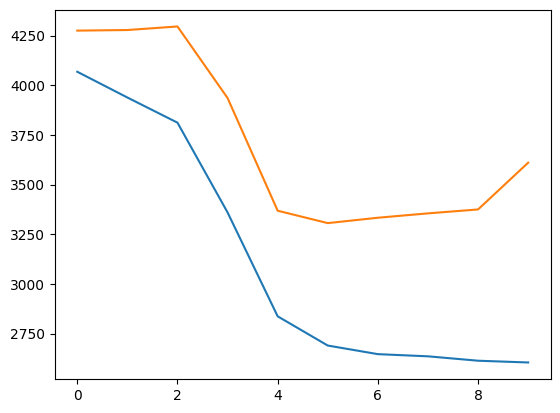

In [49]:
from matplotlib.pyplot import axis

cross_val_training_x_centered = []

mse_avg_plot = []
mse_avg_validation_plot=[]
#Cenetering the data of the 10 fold of traningset X
for x in cross_val_training_x:
    x_cv = x-x.mean(axis=0)
    cross_val_training_x_centered.append(x_cv)

for i in range(1,10+1):
    mse_avg= []
    mse_avg_alidation=[]

    for j in range(10):
        val_x = np.array(cross_val_training_x_centered[j])
        val_y = np.array(cross_val_training_y[j])
        train_x_centered = np.concatenate(np.delete(cross_val_training_x_centered, j, axis=0))
        train_y = np.concatenate(np.delete(cross_val_training_y, j, axis=0))

        pca = sklearn.decomposition.PCA(i)

        #This is xv is the same as Xcv_train*Vk in the task
        xv = pca.fit_transform(train_x_centered)
        ones_vector_1 = np.ones((xv.shape[0], 1))
        
        matrix_cv = compute_matrix(xv, train_y, ones_vector_1)
        y_vector = compute_y_vector(xv, train_y, ones_vector_1)
        result_pca = compute_result(matrix_cv, y_vector)
        w_pca = compute_w(result_pca)
        b_pca = compute_b(result_pca)

        my_cv = pca.mean_
        v = pca.components_.T
        y_new_values = []
        y_new_values_val = []

        for x_new in train_x_centered:
            y_new = (x_new - my_cv).T@v@w_pca+b_pca
            y_new_values.append(y_new)
        mse = np.sum((train_y- y_new_values)**2/len(train_x_centered))
        mse_avg.append(mse)

        for x_new in val_x:
            y_new = (x_new - my_cv).T@v@w_pca+b_pca
            y_new_values_val.append(y_new)
        mse_val = np.sum((val_y- y_new_values_val)**2/len(val_x))
        mse_avg_alidation.append(mse_val)

    mse_avg_plot.append(np.mean(mse_avg))
    mse_avg_validation_plot.append(np.mean(mse_avg_alidation))
plt.plot(mse_avg_plot)
plt.plot(mse_avg_validation_plot)
plt.show()



In [50]:
pca = sklearn.decomposition.PCA(5)
xv = pca.fit_transform(X_train-X_train.mean(axis=0))
ones_vector_1 = np.ones((xv.shape[0], 1))
matrix_cv = compute_matrix(xv, Y_train, ones_vector_1)
y_vector = compute_y_vector(xv, Y_train, ones_vector_1)
result_pca = compute_result(matrix_cv, y_vector)
my_cv = pca.mean_
v = pca.components_.T
w_pca = compute_w(result_pca)
b_pca = compute_b(result_pca)
y_new_values = []
mse_avg = []
for x_new in X_test:
    y_new = (x_new - my_cv).T@v@w_pca+b_pca
    y_new_values.append(y_new)
mse = np.sum((Y_test- y_new_values)**2/len(X_test))
print("The MSE for the PCA solution is: ", mse)

The MSE for the PCA solution is:  3535.6794526357944


In [51]:
concordant_pairs_pca, discordant_pairs_pca = find_pairs(Y_test, y_new_values)
c_index_pca = caclulate_c_index(concordant_pairs_pca, discordant_pairs_pca)
print("The c-index for the PCA solution is: ", c_index_pca)

The c-index for the PCA solution is:  0.7511444601245999


In [52]:
#Task 4h
Xtraningset = data[:300]
Xtestset = data[300:]
Ytrainset = y[:300].reshape(-1,1)
Ytestset = y[300:].reshape(-1,1)
ones_vector = np.ones((Xtraningset.shape[0], 1))

#OLS
matrix_ols = compute_matrix(Xtraningset, Ytrainset,ones_vector)
y_vector_ols = compute_y_vector(Xtraningset, Ytrainset, ones_vector)
result_ols = compute_result(matrix_ols, y_vector_ols)
w_ols = compute_w(result_ols)
b_ols = compute_b(result_ols)
mse_ols = compute_mse(Xtestset, Ytestset, w_ols, b_ols, np.ones((Xtestset.shape[0], 1)))

concordant_pairs, discordant_pairs = find_pairs(Ytestset, Xtestset@w_ols+b_ols* np.ones((Xtestset.shape[0], 1)))
c_index_ols = caclulate_c_index(concordant_pairs, discordant_pairs)
print("The MSE ols is: ", mse_ols)
print("The c-index is: ", c_index_ols)


The MSE ols is:  2794.5870008342954
The c-index is:  0.7563884156729132


In [53]:

#Ridge
matrix_ridge = compute_matrix_ridge(Xtraningset, Ytrainset,ones_vector,  10**(-1))
y_vector_ridge = compute_y_vector(Xtraningset, Ytrainset, ones_vector)
result_ridge = compute_result(matrix_ridge, y_vector_ridge)
w_ridge = compute_w(result_ridge)
b_ridge = compute_b(result_ridge)
mse_ridge = compute_mse(Xtestset, Ytestset, w_ridge, b_ridge, np.ones((Xtestset.shape[0], 1)))

concordant_pairs_ridge, discordant_pairs_ridge = find_pairs(Ytestset, Xtestset@w_ridge+b_ridge* np.ones((Xtestset.shape[0], 1)))
c_index_ridge = caclulate_c_index(concordant_pairs_ridge, discordant_pairs_ridge)
print("The MSE ridge is: ", mse_ridge)
print("The c-index is: ", c_index_ridge)


The MSE ridge is:  2783.8738430487133
The c-index is:  0.754283996392424


In [54]:

Xtraningset = data[:300]
Xtestset = data[300:]
Ytrainset = y[:300].reshape(-1,1)
Ytestset = y[300:].reshape(-1,1)
ones_vector = np.ones((Xtraningset.shape[0], 1))


pca = sklearn.decomposition.PCA(5)
xv = pca.fit_transform(Xtraningset-Xtraningset.mean(axis=0))
ones_vector_1 = np.ones((xv.shape[0], 1))
matrix_cv = compute_matrix(xv, Ytrainset, ones_vector_1)
y_vector = compute_y_vector(xv, Ytrainset, ones_vector_1)
result_pca = compute_result(matrix_cv, y_vector)
my_cv = pca.mean_
v = pca.components_.T
w_pca = compute_w(result_pca)
b_pca = compute_b(result_pca)
y_new_values = []
mse_avg = []
for x_new in Xtestset:
    y_new = (x_new - my_cv).T@v@w_pca+b_pca
    y_new_values.append(y_new)
mse_pca = np.sum((Ytestset- y_new_values)**2/len(Xtestset))

concordant_pairs_pca, discordant_pairs_pca = find_pairs(Ytestset, y_new_values)
c_index_pca = caclulate_c_index(concordant_pairs_pca, discordant_pairs_pca)

print("The MSE PCA is: ", mse_pca)
print("The c-index is: ", c_index_pca)


The MSE PCA is:  2909.7205289633775
The c-index is:  0.7507766309249424


In [55]:
#4i
import sklearn.neighbors


In [56]:

X_train_fold = [Xtraningset[:30], Xtraningset[30:60], Xtraningset[60:90], Xtraningset[90:120],
 Xtraningset[120:150],Xtraningset[150:180], Xtraningset[180:210],Xtraningset[210:240], Xtraningset[240:270], Xtraningset[270:300]]

y_train_folds= [Ytrainset[:30], Ytrainset[30:60], Ytrainset[60:90], Ytrainset[90:120],
 Ytrainset[120:150],Ytrainset[150:180], Ytrainset[180:210],Ytrainset[210:240], Ytrainset[240:270], Ytrainset[270:300]]


In [64]:

k_values = [1, 2, 3, 5, 10, 20, 30, 50, 100]

mse_mean = []

for i, (val_x, val_y)  in enumerate(zip(X_train_fold, y_train_folds)):

    mse_values = []

    for k in k_values:

        train_x = np.concatenate(np.delete(X_train_fold, i, axis=0))
        train_y = np.concatenate(np.delete(y_train_folds, i, axis=0))

        knn = sklearn.neighbors.KNeighborsRegressor(k)
        knn.fit(train_x, train_y)
        y_predicted_knn = knn.predict(val_x)
        
        #print(y_predicted_knn)
        tmp = y_predicted_knn[1:]
        y_predicted_knn = np.concatenate([tmp, y_predicted_knn[0:1]])
        print(y_predicted_knn)

        mse = np.sum((val_y-y_predicted_knn)**2/len(y_predicted_knn))
        mse_values.append(mse)

    mse_mean.append(np.mean(mse_values))
print(mse_mean)
lowest_k = k_values[np.argmin(mse_mean)]
lowest_k, mse_mean

[[ 52.]
 [225.]
 [151.]
 [ 79.]
 [143.]
 [116.]
 [ 80.]
 [145.]
 [ 52.]
 [ 99.]
 [ 55.]
 [ 88.]
 [265.]
 [ 59.]
 [138.]
 [202.]
 [138.]
 [ 93.]
 [115.]
 [ 59.]
 [ 77.]
 [113.]
 [310.]
 [200.]
 [ 61.]
 [ 85.]
 [276.]
 [182.]
 [202.]
 [225.]]
[[ 83.5]
 [176. ]
 [182.5]
 [ 64.5]
 [121. ]
 [ 99.5]
 [109. ]
 [171. ]
 [ 75.5]
 [142. ]
 [100. ]
 [ 73.5]
 [153.5]
 [ 70. ]
 [183.5]
 [233.5]
 [130. ]
 [146.5]
 [137.5]
 [110.5]
 [ 96.5]
 [121. ]
 [302.5]
 [164.5]
 [ 93.5]
 [135. ]
 [198.5]
 [106.5]
 [155. ]
 [176. ]]
[[ 85.66666667]
 [145.        ]
 [203.66666667]
 [ 94.33333333]
 [101.        ]
 [ 92.        ]
 [129.33333333]
 [146.33333333]
 [138.66666667]
 [123.        ]
 [114.66666667]
 [ 76.        ]
 [134.66666667]
 [ 64.        ]
 [196.33333333]
 [171.66666667]
 [165.        ]
 [167.66666667]
 [121.        ]
 [135.33333333]
 [ 77.33333333]
 [141.33333333]
 [275.        ]
 [157.        ]
 [109.66666667]
 [123.        ]
 [175.33333333]
 [113.33333333]
 [187.33333333]
 [186.66666667]]
[[ 94.2

(5,
 [6218.35347855967,
  9328.334280082305,
  5832.653533333333,
  5221.722456419753,
  7718.81969707819,
  10015.900984897118,
  6103.218707572016,
  9232.759359835392,
  11742.465785308641,
  9782.364604320988])

In [65]:

knn_best = sklearn.neighbors.KNeighborsRegressor(lowest_k)
fit_knn = knn_best.fit(X_train, Y_train)
y_predict = knn_best.predict(X_test)
mse_knn = np.sum((Y_test-y_predict)**2/len(Y_test))

concordant_pairs_knn, discordant_pairs_knn = find_pairs(Y_test, y_predict)
c_index_knn = caclulate_c_index(concordant_pairs_knn, discordant_pairs_knn)

print("MSE for KNN is: ", mse_knn)
print("C-index for KNN: : ", c_index_knn)


MSE for KNN is:  4706.19052631579
C-index for KNN: :  0.6966040337872781
